In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import arrow
from datetime import datetime
import pandas as pd

In [2]:
file = 'RCM3_SHUB_2023_07_17_10_33_50_0742905230_112.36E_20.59N_VH_C-10_MERGED02_wind_level2.nc'
#'RCM3_SHUB_2023_07_24_09_52_11_0743507531_124.99E_16.08N_HV_C-10_MERGED01_wind_level2.nc'
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:                 (y: 1016, x: 713, xfit: 6)
Coordinates:
    longitude               (y, x) float32 ...
    latitude                (y, x) float32 ...
Dimensions without coordinates: y, x, xfit
Data variables: (12/59)
    acquisition_time        datetime64[ns] ...
    nx                      int32 ...
    ny                      int32 ...
    nx0                     int32 ...
    ny0                     int32 ...
    nx00                    int32 ...
    ...                      ...
    incid_coef              (xfit) float64 ...
    incid_xexp              (xfit) float32 ...
    incid_yexp              (xfit) float32 ...
    rlook_coef              (xfit) float64 ...
    rlook_xexp              (xfit) float32 ...
    rlook_yexp              (xfit) float32 ...
Attributes: (12/81)
    title:                                  SAR winds at 10-m height neutral ...
    source:                                 SAR imagery BLANK
    history:                           

In [3]:
wind = ds.sar_wind
lat = ds.latitude
lon = ds.longitude

In [4]:
datetime64 = ds['acquisition_time'].values
pd.Timestamp(datetime64).to_pydatetime()
time = arrow.get(pd.Timestamp(datetime64).to_pydatetime())
time_str = time.to('Asia/Shanghai').format('YYYY-MM-DD HH:mm')


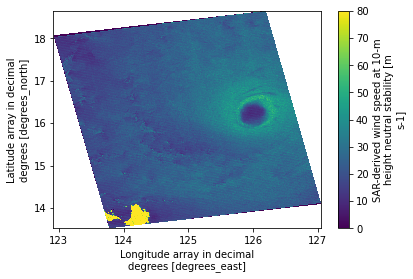

In [5]:
# plot wind with coords lat and lon
wind.plot(x='longitude', y='latitude')

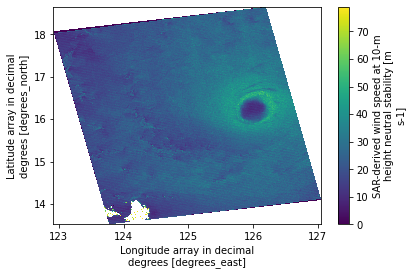

In [6]:
# mask wind values greater than 70
wind_masked = wind.where(wind < 80)
wind_masked.plot(x='longitude', y='latitude')

In [7]:
def contour_map(ax,img_extent,latspec,lonspec):
    leftlon=img_extent[0]
    rightlon=img_extent[1]
    lowerlat=img_extent[2]
    upperlat=img_extent[3]
    ax.set_extent(img_extent, crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(leftlon,rightlon+lonspec,lonspec), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lowerlat,upperlat+latspec,latspec), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

<Figure size 432x288 with 0 Axes>

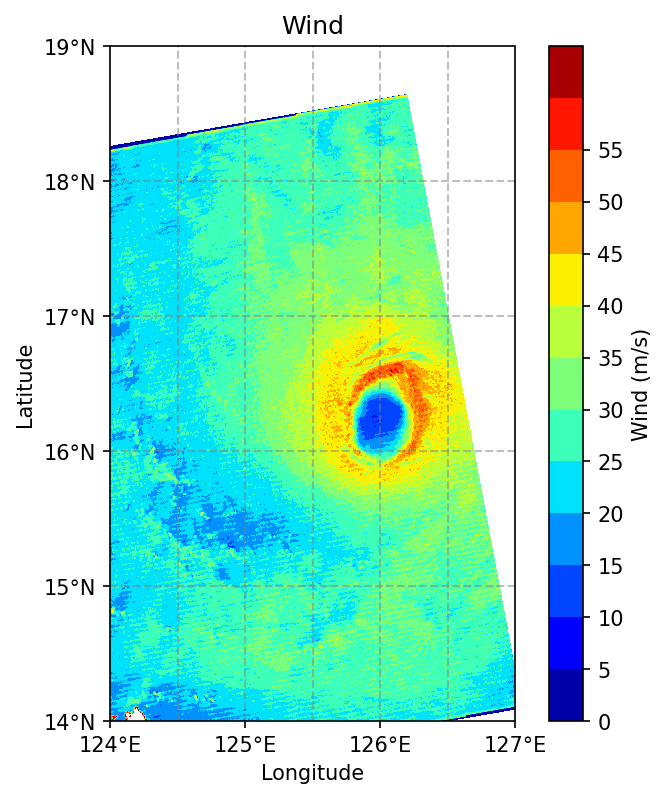

In [8]:
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(15, 15), dpi=150)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
leftlon, rightlon, lowerlat, upperlat = (124,127,14,18.5)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,1,1)

# wind[wind.where(wind>70)] = np.nan
# ax.coastlines()
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'))


cf = ax.contourf(lon, lat, wind_masked, levels=np.arange(0,70,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)
china = shpreader.Reader('F:/github/pythonScript/mon5/china_basic_map/bou2_4p.shp').geometries()
ax.add_geometries(china, ccrs.PlateCarree(),facecolor='white', edgecolor='black',zorder = 2)
# show color bar
#添加色标
# cbposition=fig.add_axes([0.13, 0.75, 0.4, 0.015])
# fig.colorbar(cf,cax=cbposition,orientation='horizontal',format='%.1f',)
cb = plt.colorbar(cf)
# set colorbar label and ticks np.arange(0,60,5)
cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))

# plot gridline use cartopy
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
# plot lon and lat axes label
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title('Wind')
plt.show()

<Figure size 432x288 with 0 Axes>

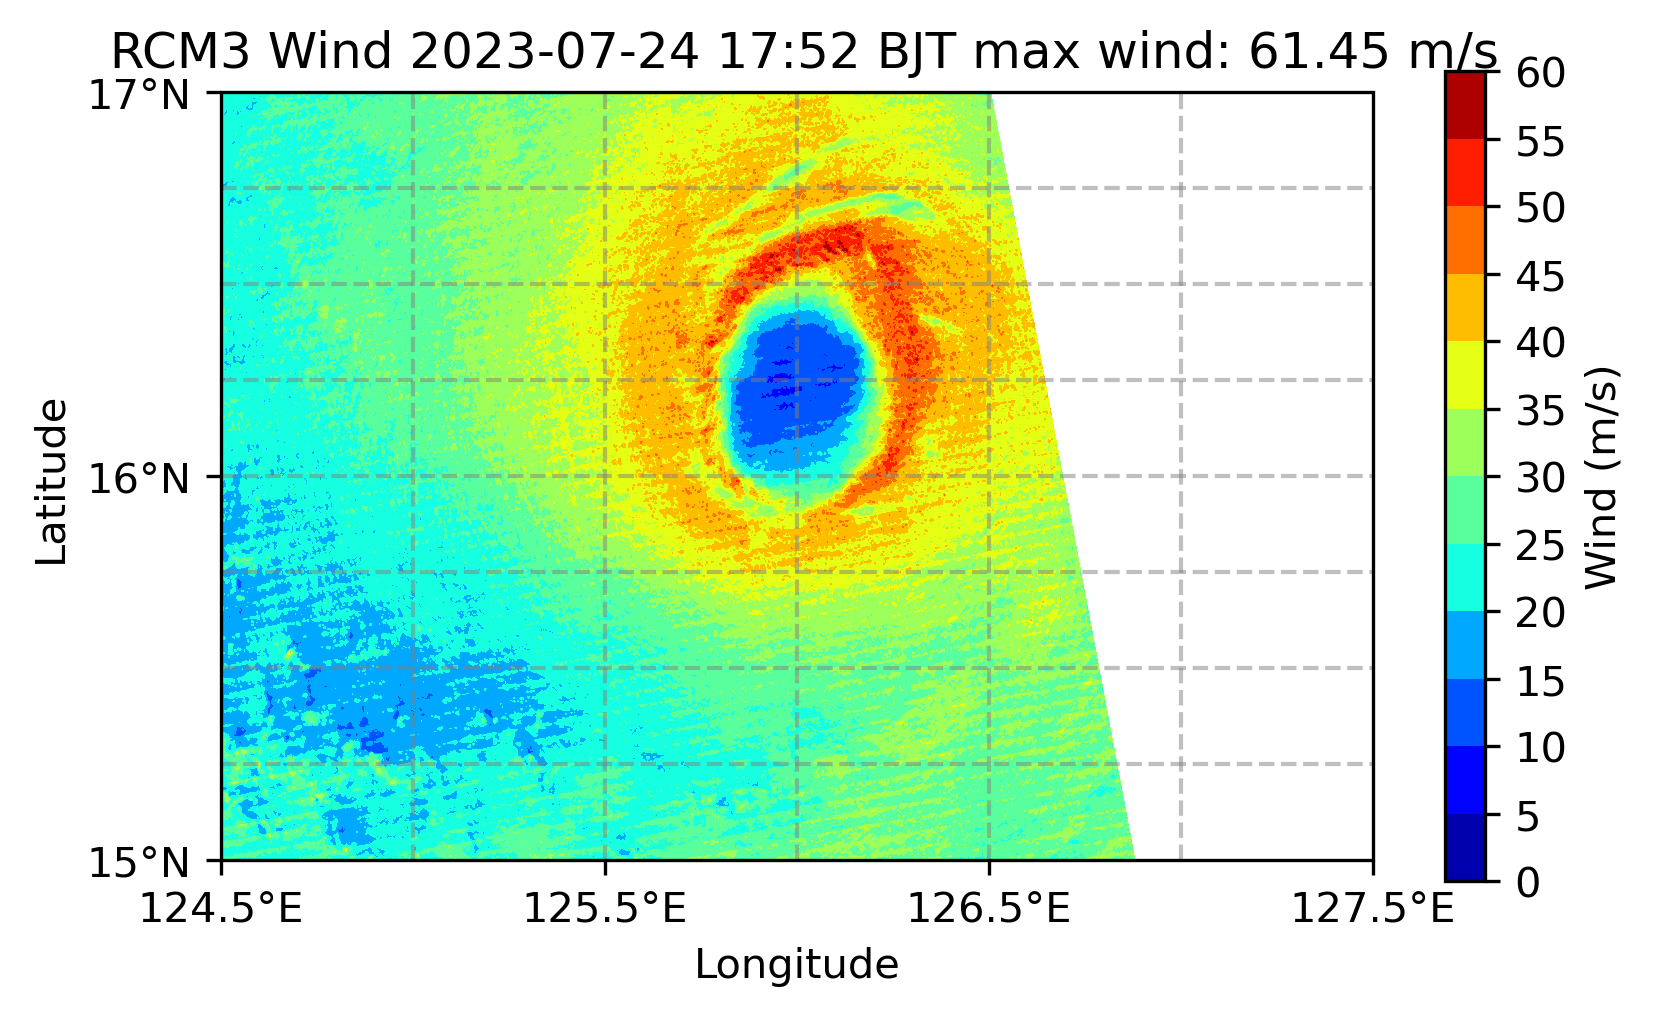

In [9]:
leftlon, rightlon, lowerlat, upperlat = (124.5,127,15,17)

# 创建一个布尔数组，指示每个数据点是否在给定的经纬度范围内
mask = ((wind.longitude >= leftlon) & (wind.longitude <= rightlon) & 
        (wind.latitude >= lowerlat) & (wind.latitude <= upperlat))

# 使用布尔数组选择数据
selected_data = wind.where(mask, drop=True)
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,1,1)


cf = ax.contourf(selected_data.longitude, selected_data.latitude, selected_data, levels=np.arange(0,65,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)

cb = plt.colorbar(cf)

cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,65,5))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
wind_max = selected_data.max()
plt.title(f' RCM3 Wind {time_str} BJT max wind: {wind_max:.2f} m/s')
plt.show()

<Figure size 432x288 with 0 Axes>

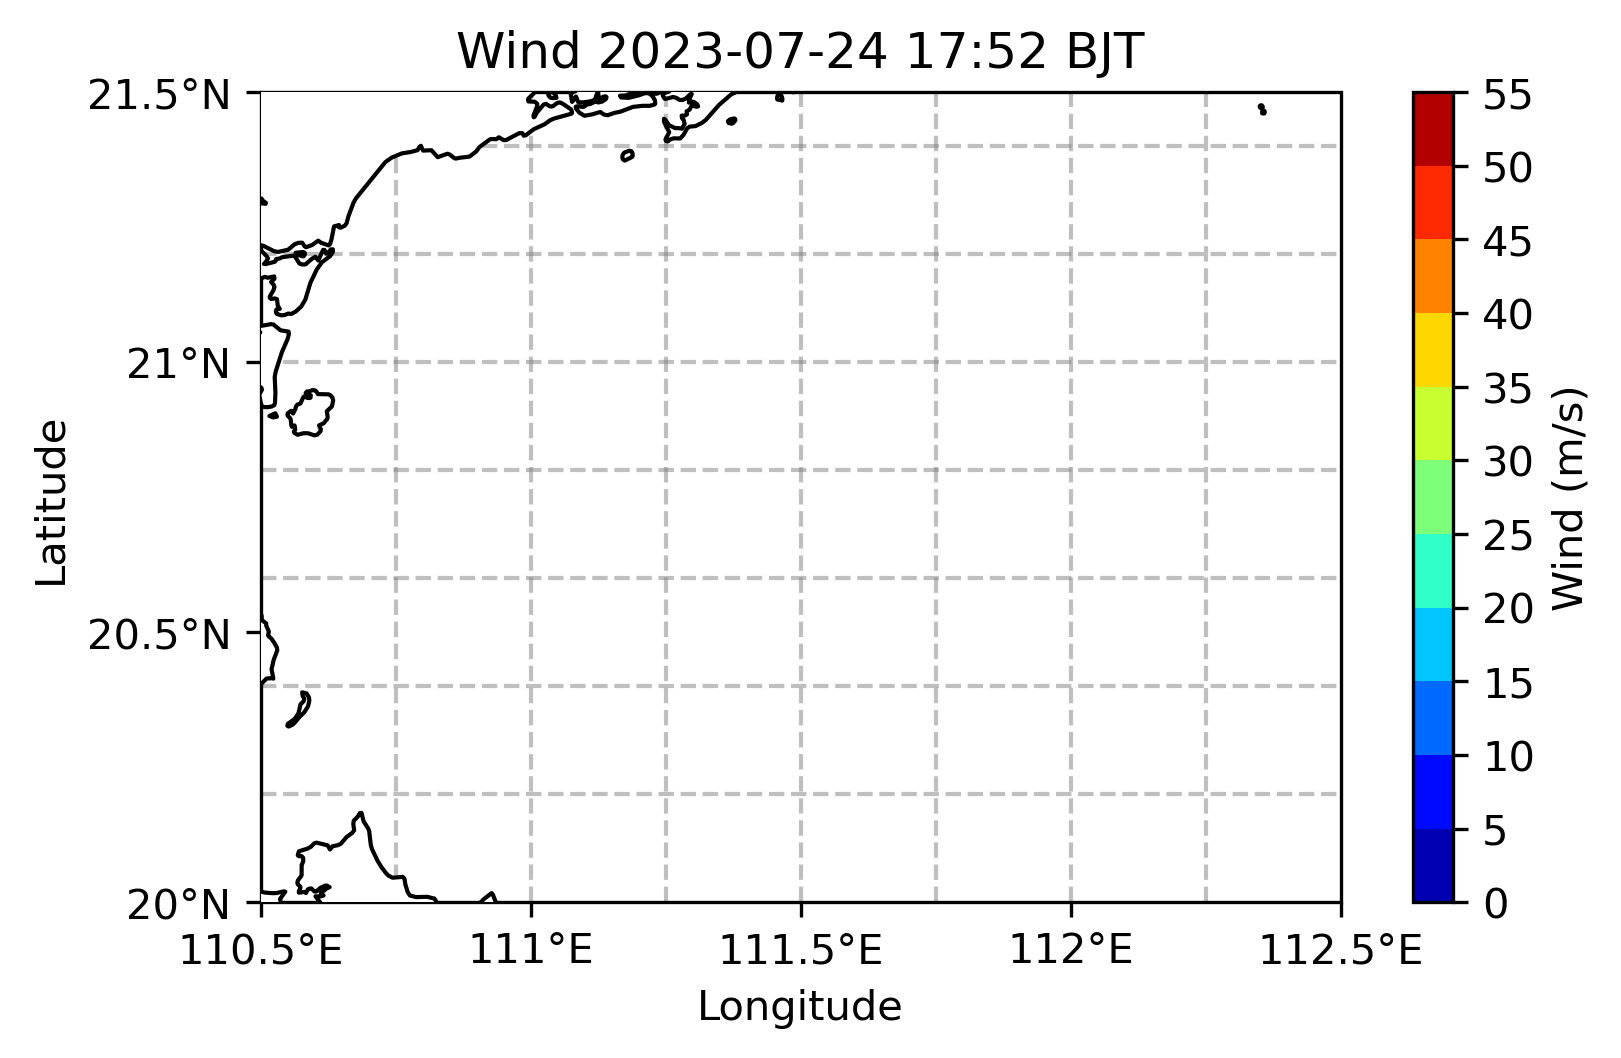

In [10]:
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
leftlon, rightlon, lowerlat, upperlat = (110.5,112.5,20,21.5)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,0.5,0.5)

# wind[wind.where(wind>70)] = np.nan
# ax.coastlines()
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'))


cf = ax.contourf(lon, lat, wind_masked, levels=np.arange(0,60,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)
# draw contour
# cr = ax.contour(lon, lat, wind_masked, levels=np.arange(40,50,1), transform=ccrs.PlateCarree(), colors='black', zorder = 2)
china = shpreader.Reader('F:/github/pythonScript/mon5/china_basic_map/bou2_4p.shp').geometries()
ax.add_geometries(china, ccrs.PlateCarree(),facecolor='white', edgecolor='black',zorder = 3)
# show color bar
#添加色标
# cbposition=fig.add_axes([0.13, 0.75, 0.4, 0.015])
# fig.colorbar(cf,cax=cbposition,orientation='horizontal',format='%.1f',)
cb = plt.colorbar(cf)
# set colorbar label and ticks np.arange(0,60,5)
cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))

# plot gridline use cartopy
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
# plot lon and lat axes label
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title(f'Wind {time_str} BJT')
plt.show()

<Figure size 432x288 with 0 Axes>

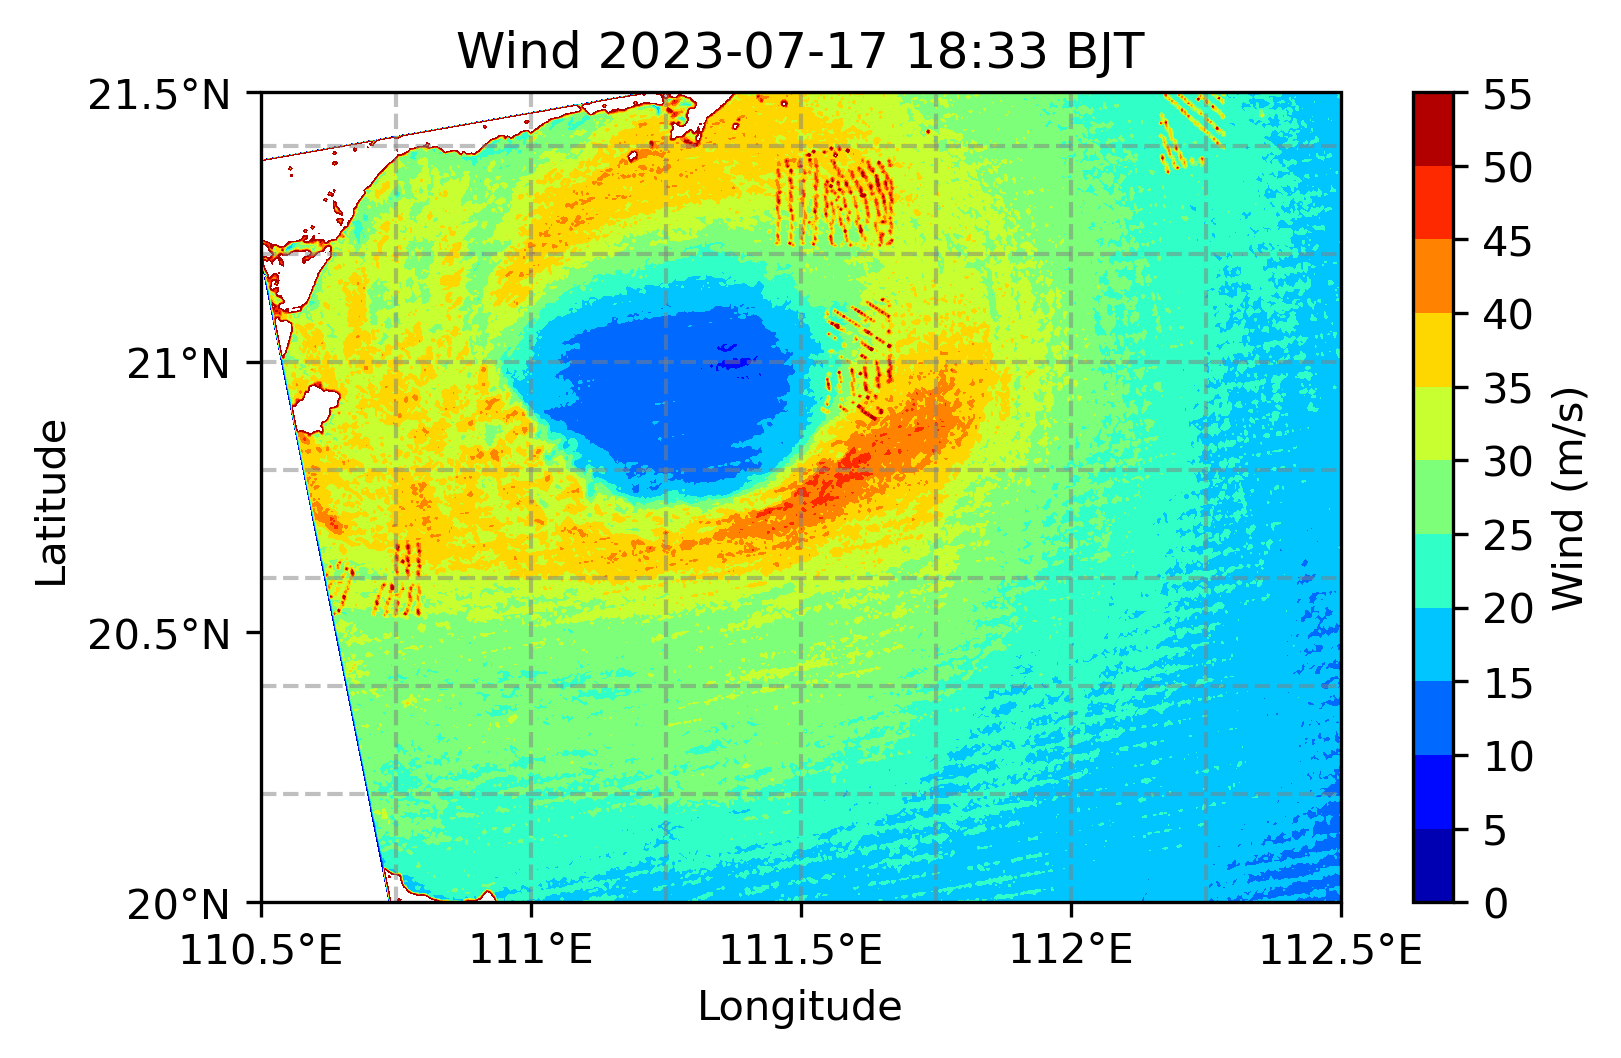

In [111]:
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
leftlon, rightlon, lowerlat, upperlat = (110.5,112.5,20,21.5)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,0.5,0.5)

# wind[wind.where(wind>70)] = np.nan
# ax.coastlines()
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'))


cf = ax.contourf(lon, lat, wind, levels=np.arange(0,60,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)
# draw contour
# cr = ax.contour(lon, lat, wind_masked, levels=np.arange(40,50,1), transform=ccrs.PlateCarree(), colors='black', zorder = 2)
# china = shpreader.Reader('F:/github/pythonScript/mon5/china_basic_map/bou2_4l.shp').geometries()
# ax.add_geometries(china, ccrs.PlateCarree(),facecolor='None', edgecolor='black',zorder = 3)
# show color bar
#添加色标
# cbposition=fig.add_axes([0.13, 0.75, 0.4, 0.015])
# fig.colorbar(cf,cax=cbposition,orientation='horizontal',format='%.1f',)
cb = plt.colorbar(cf)
# set colorbar label and ticks np.arange(0,60,5)
cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))

# plot gridline use cartopy
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
# plot lon and lat axes label
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title(f'Wind {time_str} BJT')
plt.show()

In [ ]:
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=150)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
leftlon, rightlon, lowerlat, upperlat = (110.5,112.5,20,21.5)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,0.5,0.5)

# wind[wind.where(wind>70)] = np.nan
# ax.coastlines()
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'))


cf = ax.contourf(lon, lat, wind_masked, levels=np.arange(0,60,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)
# draw contour
# cr = ax.contour(lon, lat, wind_masked, levels=np.arange(40,50,1), transform=ccrs.PlateCarree(), colors='black', zorder = 2)
china = shpreader.Reader('F:/github/pythonScript/mon5/china_basic_map/bou2_4p.shp').geometries()
ax.add_geometries(china, ccrs.PlateCarree(),facecolor='white', edgecolor='black',zorder = 3)
# show color bar
#添加色标
# cbposition=fig.add_axes([0.13, 0.75, 0.4, 0.015])
# fig.colorbar(cf,cax=cbposition,orientation='horizontal',format='%.1f',)
cb = plt.colorbar(cf)
# set colorbar label and ticks np.arange(0,60,5)
cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))

# plot gridline use cartopy
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
# plot lon and lat axes label
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title(f'Wind {time_str} BJT')
plt.show()

In [101]:
fb_mm = [111.526,20.719]
distance = np.sqrt(np.square(lon-fb_mm[0])+np.square(lat-fb_mm[1]))

In [102]:
# 找出距离最近的9个点和这9个点的索引
distance_1d = distance.values.flatten()
distance_1d_sort = np.sort(distance_1d)
distance_1d_sort_index = np.argsort(distance_1d)
distance_1d_sort_index_9 = distance_1d_sort_index[0:9]
distance_1d_sort_9 = distance_1d_sort[0:9]
print(distance_1d_sort_9)

[0.00059146 0.00397571 0.00478957 0.00484921 0.00515632 0.00611463
 0.00632379 0.00698184 0.00708505]


In [104]:
# distance_1d_sort_index_9 还原为原2D索引
distance_1d_sort_index_9_2d = np.unravel_index(distance_1d_sort_index_9, distance.shape)
print(distance_1d_sort_index_9_2d)

(array([449, 448, 449, 449, 450, 448, 448, 450, 450], dtype=int64), array([191, 191, 192, 190, 191, 192, 190, 190, 192], dtype=int64))


In [123]:
wind.longitude

<xarray.DataArray 'longitude' (y: 1019, x: 712)>
array([[110.22528 , 110.229996, 110.23471 , ..., 113.569435, 113.57415 ,
        113.57887 ],
       [110.22617 , 110.23089 , 110.2356  , ..., 113.57032 , 113.575035,
        113.57976 ],
       [110.227066, 110.23178 , 110.236496, ..., 113.571205, 113.57592 ,
        113.58064 ],
       ...,
       [111.13187 , 111.13657 , 111.14127 , ..., 114.46794 , 114.47265 ,
        114.477356],
       [111.13276 , 111.13746 , 111.142166, ..., 114.46882 , 114.473526,
        114.47823 ],
       [111.133644, 111.13835 , 111.14305 , ..., 114.4697  , 114.47441 ,
        114.47912 ]], dtype=float32)
Coordinates:
    longitude  (y, x) float32 110.2 110.2 110.2 110.2 ... 114.5 114.5 114.5
    latitude   (y, x) float32 22.57 22.57 22.57 22.57 ... 18.59 18.59 18.6 18.6
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_east
    long_name:      Longitude array in decimal degrees
    standard_name:  longitude

<Figure size 432x288 with 0 Axes>

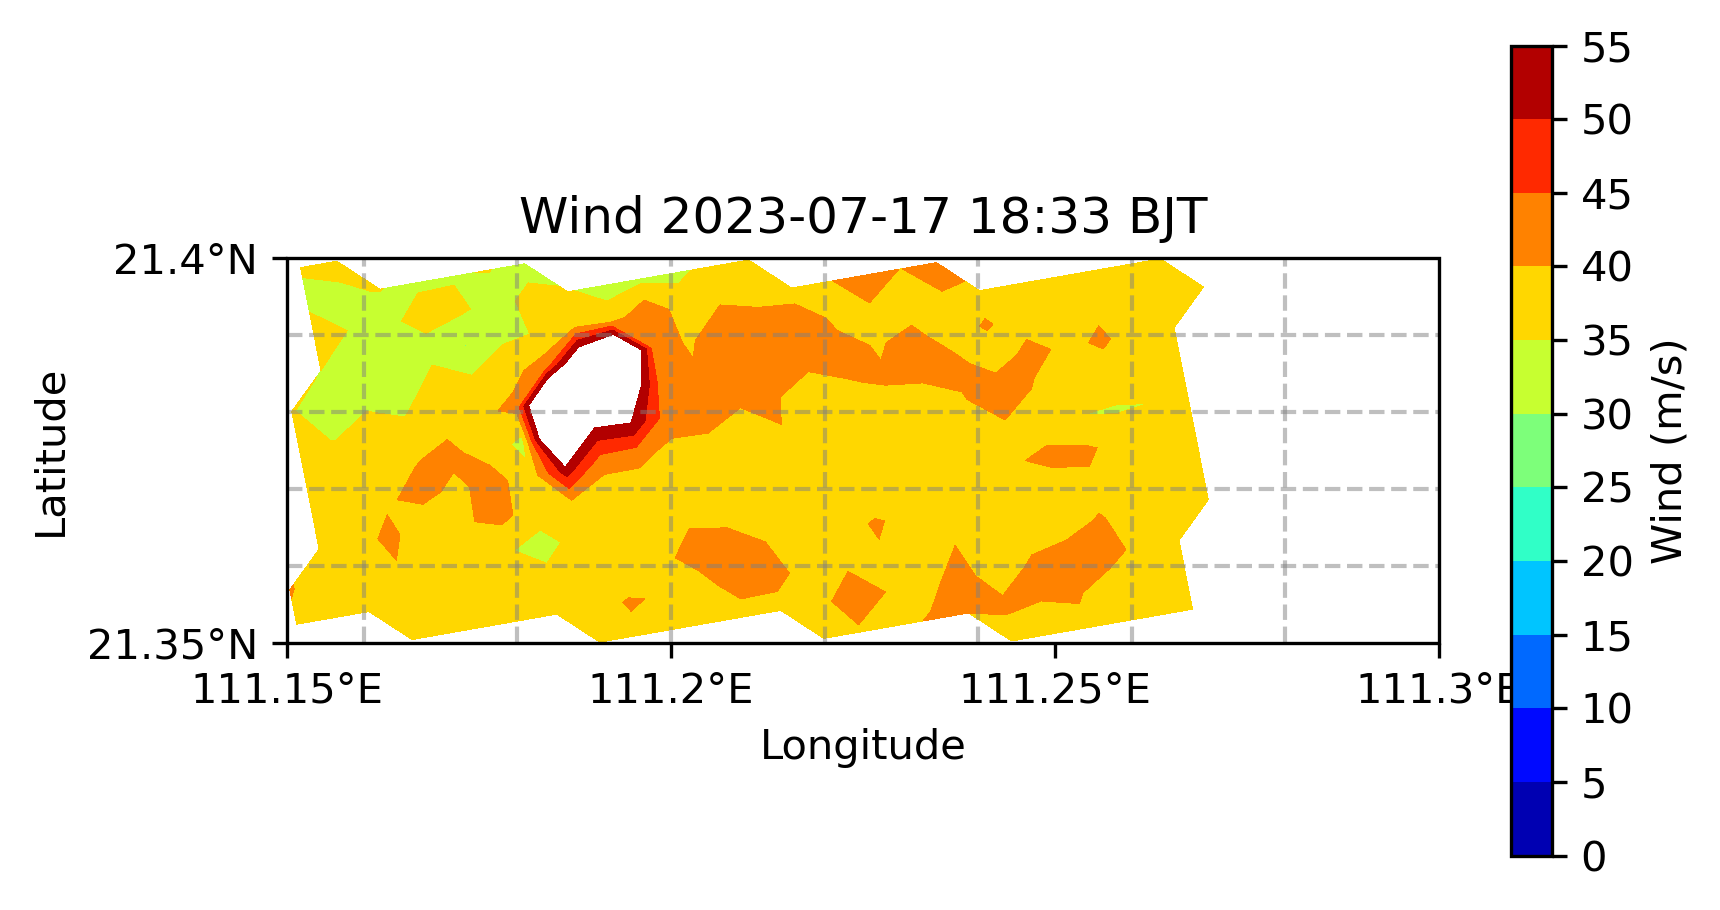

In [131]:
leftlon, rightlon, lowerlat, upperlat = (111.15,111.27,21.35,21.4)

# 创建一个布尔数组，指示每个数据点是否在给定的经纬度范围内
mask = ((wind.longitude >= leftlon) & (wind.longitude <= rightlon) & 
        (wind.latitude >= lowerlat) & (wind.latitude <= upperlat))

# 使用布尔数组选择数据
selected_data = wind.where(mask, drop=True)

# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,0.05,0.05)


cf = ax.contourf(selected_data.longitude, selected_data.latitude, selected_data, levels=np.arange(0,60,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)

cb = plt.colorbar(cf)

cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title(f'Wind {time_str} BJT')
plt.show()

<Figure size 432x288 with 0 Axes>

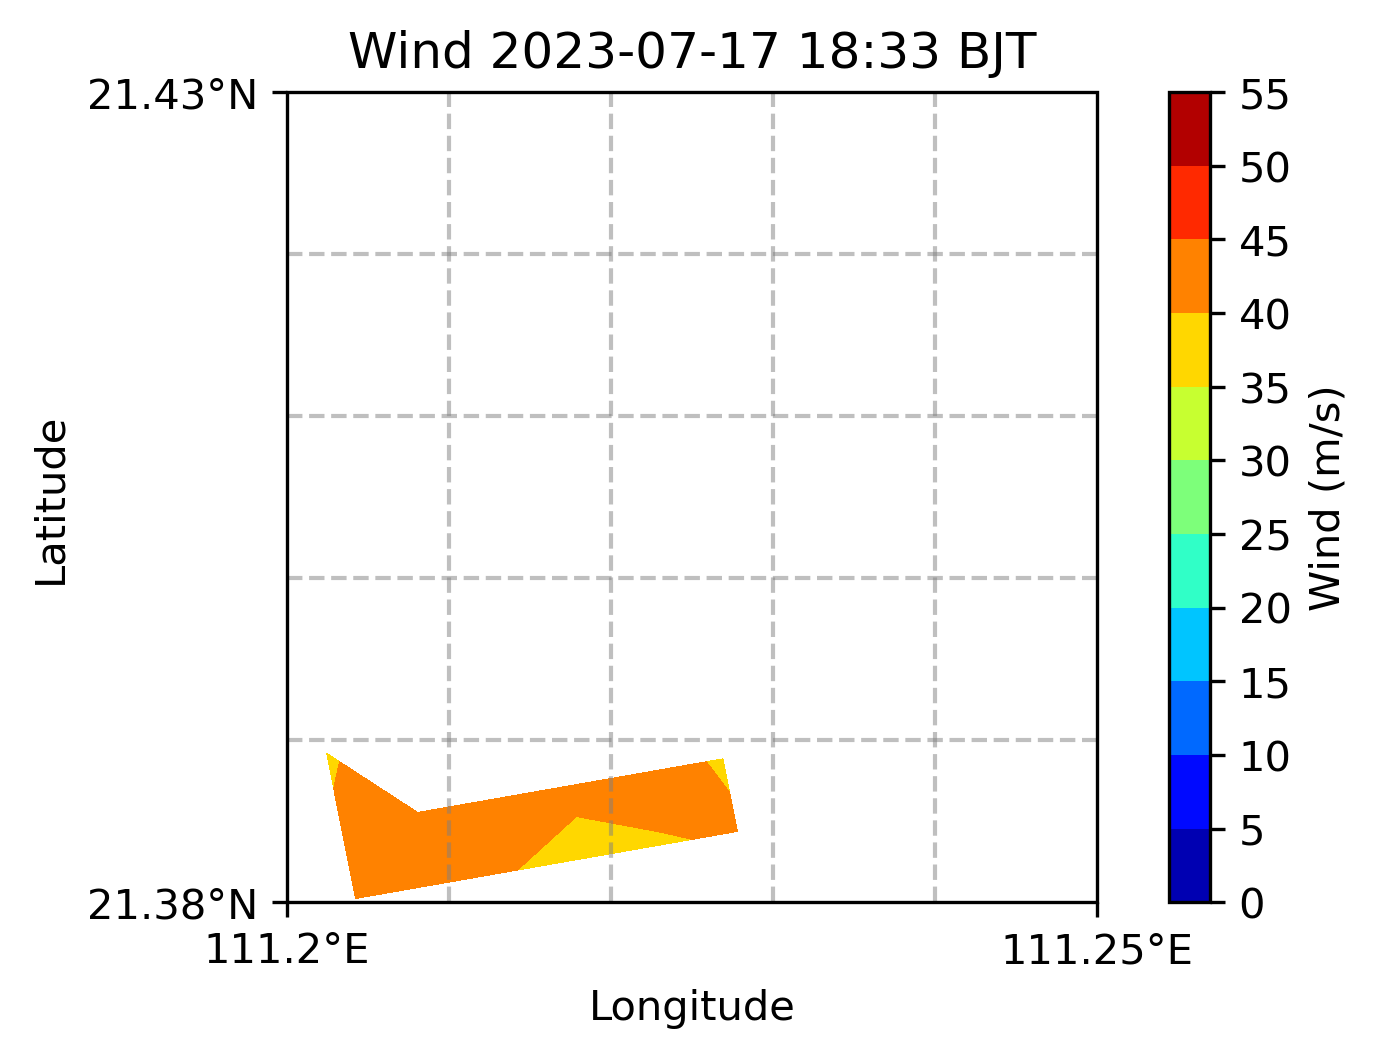

In [134]:
leftlon, rightlon, lowerlat, upperlat = (111.2,111.23,21.38,21.39)

# 创建一个布尔数组，指示每个数据点是否在给定的经纬度范围内
mask = ((wind.longitude >= leftlon) & (wind.longitude <= rightlon) & 
        (wind.latitude >= lowerlat) & (wind.latitude <= upperlat))

# 使用布尔数组选择数据
selected_data = wind.where(mask, drop=True)
# use matplotlib and cartopy contour wind with coords lat and lon
plt.clf()
fig = plt.figure(figsize=(16, 9), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.3, 0.3],projection = ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
img_extent = [leftlon, rightlon, lowerlat, upperlat]
contour_map(ax,img_extent,0.05,0.05)
cf = ax.contourf(selected_data.longitude, selected_data.latitude, selected_data, levels=np.arange(0,60,5), transform=ccrs.PlateCarree(), cmap='jet', zorder = 1)
cb = plt.colorbar(cf)
cb.set_label('Wind (m/s)')
cb.set_ticks(np.arange(0,60,5))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plot title
plt.title(f'Wind {time_str} BJT')
plt.show()

In [136]:
selected_data.values

array([[39.338326,       nan,       nan,       nan,       nan,       nan],
       [40.704353, 44.027523, 42.610058, 41.94056 , 41.164524, 39.678127],
       [42.38298 , 40.283463, 40.354725, 37.371075, 39.74301 , 40.3709  ]],
      dtype=float32)

In [109]:
# 根据索引取出9个点的风速
wind_list = []
for i in range(9):
    wind_value = wind_masked[distance_1d_sort_index_9_2d[0][i],distance_1d_sort_index_9_2d[1][i]].values.item()
    wind_list.append(wind_value)
print(wind_list)
# 大放鸡岛

[46.5261344909668, 40.68345260620117, 42.310123443603516, 42.81689453125, 41.48638916015625, 42.707706451416016, 44.55961990356445, 40.83684539794922, 41.93657302856445]


In [79]:
'2023-07-17 22:27:09'
'2023-07-16 10:25:13'
'2023-07-16 22:19:12'
'2023-07-17 10:33:50'

1689590030000000000

In [ ]:
'2023-07-16 10:20:00'
'2023-07-16 10:25:00'
'2023-07-16 10:30:00'

'2023-07-16 22:10:00'
'2023-07-16 22:15:00'
'2023-07-16 22:20:00'

'2023-07-17 10:30:00'
'2023-07-17 10:35:00'
'2023-07-17 10:40:00'

'2023-07-17 22:20:00'
'2023-07-17 22:25:00'
'2023-07-17 22:30:00'

